Cette page propose une familiarisation avec l'objet "*sinusoïde discrète*", dont les propriétés peuvent être déroutantes de prime abord. 

In [1]:
import numpy as np
from matplotlib import pylab as plt
import wave
import IPython
from scipy import fftpack as fft
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from math import floor
from scipy import signal as sig
%matplotlib inline

# Casting unitary numbers to real numbers will give errors
# because of numerical rounding errors. We therefore disable 
# warning messages.
import warnings
# warnings.filterwarnings('ignore')

# Set common figure parameters
newparams = {'axes.labelsize': 12, 'axes.linewidth': 1, 'savefig.dpi': 200,
             'lines.linewidth': 1, 'figure.figsize': (6, 6),
             'ytick.labelsize': 7, 'xtick.labelsize': 10,
             'ytick.major.pad': 5, 'xtick.major.pad': 5,
             'legend.fontsize': 10, 'legend.frameon': True, 
             'legend.handlelength': 1.5, 'axes.titlesize': 12,}
plt.rcParams.update(newparams)

def tone(frequency=440., length=1., amplitude=1., sampleRate=44100., soundType='int8'):
    """ Returns a sine function representing a tune with a given frequency.
    
    :frequency: float/int. Frequency of the tone.
    :length: float/int. Length of the tone in seconds.
    :amplitude: float/int. Amplitude of the tone.
    :sampleRate: float/int. Sampling frequency.
    :soundType: string. Type of the elements in the returned array.
    :returns: float numpy array. Sine function representing the tone.
    """
    t = np.linspace(0,length,floor(length*sampleRate))
    data = amplitude*np.sin(2*np.pi*frequency*t)
    return data.astype(soundType)

# Parameters that are being used in the start of this notebook
sampleRate = 44100     # La fréquence d'échantillonnage, celle d'un CD audio ordinaire
sampwidth = 1          # In bytes. 1 for 8 bit, 2 for 16 bit and 4 for 32 bit
volumePercent = 50     # Volume percentage
nchannels = 1          # Mono. Only mono works for this notebook

# Some dependent variables
shift = 128 if sampwidth == 1 else 0 # The shift of the 8 bit samples, as explained in the section above.
soundType = 'i' + str(sampwidth)
amplitude = np.iinfo(soundType).min*volumePercent/100.

## VII.1. Condition de bon échantillonnage : Le théorème de Shannon-Nyquist

Lorsque nous traitons un signal audio numérique à l'aide d'un ordinateur, nous devons discrétiser (et échantillonner) un signal analogique, initialement à temps continu (et à valeurs réelles). Avant d'aller plus loin, il convient de discuter brièvement du **théorème d'échantillonnage de Shannon-Nyquist**, qui précise comment échantillonner correctement un signal, via une condition sur la fréquence d'échantillonnage $f_s$ (ou $f_e$). 

Intuitivement, on comprend facilement qu'un signal qui varie lentement peut être échantillonné à une fréquence d'échantillonnage modérée, alors qu'on utilisera une fréquence d'échantillonnage plus élevée pour pouvoir rendre compte d'un signal analogique caractérisé par des variations rapides. En d'autres termes, c'est le contenu fréquentiel (spectral) d'un signal, et particulièrement la fréquence maximale ($B Hz$, B pour *bandwidth* ou *bande passante*) qui caractérise son spectre (unilatéral, de domaine $[0;BHz]$), qui va déterminer la fréquence d'échantillonnage (minimale) à utiliser pour échantillonner correctement le signal analogique.       

Le **théorème d'échantillonnage** (dit également de Shannon-Nyquist) stipule que pour échantillonner correctement un signal (ce qui veut dire (1) ne pas faire d'erreur sur ses caractéristiques, et (2) pouvoir retrouver exactement le signal analogique de départ à partir de ses échantillons), la fréquence d'échantillonnage doit être supérieure à deux fois la fréquence la plus élevée du signal. C.E. Shannon l'a formulé comme suit :

> Si un signal analogique $s(t)$ ne contient pas de fréquences plus grandes que $B Hz$, celui-ci est complétement déterminé par les valeurs prises en une série de points séparés de $\frac{1}{\frac{B}{2}}$ secondes.

En pratique, cela signifie que la fréquence d'échantillonnage d'un signal de bande passante limitée à B Hz doit être au moins égale au double de la bande passante, soit $2B \ Hz$. Dans les exemples du TP I consacré aux ondes sonores sinusoïdales, vous avez utilisé une fréquence d'échantillonnage de 44100 Hz (celle des CD "ordinaires"), qui permet de représenter l'ensemble des fréquences audibles, puisque la gamme perceptible à l'audition humaine est d'environ 20 à 20 000 Hz (i.e. $B=20\ kHz$). 

Un autre façon de considérer le théorème de Shannon-Nyquist est la suivante : si on considère la fréquence d'échantillonnage fixée à $f_s$, le signal analogique ne devrait pas contenir de composantes (de sinusoïdes) de fréquences supérieures à $\frac{B}{2} \ Hz$, fréquence maximale qu'on nomme d'ailleurs "**Fréquence de Nyquist"**. Cette condition d'échantillonnage correct est nommée le : 

> **Critère de Nyquist :** $f_{Maximum} \leq \frac{f_s}{2}$  

Les composantes fréquentielles qui ne satisfont pas au critère de Nyquist apparaîtront, dans le signal à temps discret résultant de l'échantillonnage, à des fréquences apparentes plus faibles que leur fréquence initiale : c'est le **repliement spectral** (ou ***aliasing*** en anglais). Comme vous l'expérimenterez ci-dessous, on constate expérimentalement que la fréquence apparente d'une sinusoïde à temps discret ne peut dépasser la fréquence de Nyquist, qui apparaît comme la fréquence maximale que peut prendre toute sinusoïde à temps discret échantillonnée à $f_s$.  


## Le repliement spectral ("Aliasing")

Le danger d'un un échantllonnage mal réalisé (par exemple, d'un signal sinusoïdal de fréquence $f_0$ à une fréquence d'échantillonnage $f_s \leq 2f_0$) est d'aboutir par repliement spectral vers un signal dont la fréquence ne reflète pas celle du signal analogique que l'on échantillonne. Par exemple, si la fréquence d'échantillonnage est $f_s$, les fréquences $f_0$ et $f_s-f_0$ sont indiscernables. Comme vous l'entendrez ci-dessous, toutes les composantes (sinusoïdales) de fréquences supérieures à $\frac{f_s}{2}$ seront réfléchies autour de $\frac{f_s}{2}$ vers les fréquences décroissantes.

Dans ce qui suit, nous créons un fichier audio où la fréquence de composantes sinusoïdales augmente progressivement de 0 Hz à la fréquence d'échantillonnage choisie de 5000 Hz. Comme nous le remarquons rapidement, ce que nous entendons n'est pas l'augmentation progressive de la fréquence à laquelle nous nous attendons intuitivement, mais une augmentation progressive de la fréquence suivie d'une diminution progressive lorsque $f_0$ dépasse $\frac{f_s}{2}$.


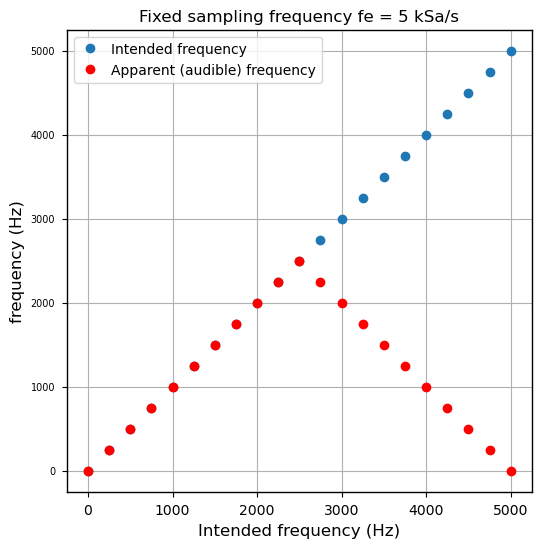

In [2]:
sampleRate = 5000
length = .5
NP = 21
 
# increasing frequencies of he melody 
melody = np.linspace(0, sampleRate, NP)

# Apparent frequencies with aliasing for f > sampleRate/2
fap1=melody[0:floor(NP/2)]
# fap2=np.linspace(sampleRate/2,0,floor(NP/2))
fap2=melody[floor(NP/2):0:-1]
fap=np.concatenate((fap1,fap2))
fap=np.concatenate((fap,[0]))

data = np.array([],dtype=soundType)
for frequency in melody:
    currentTone = tone(frequency, length, amplitude, sampleRate, soundType)
    data = np.append(data, currentTone)
data += shift
with wave.open('aliasing2.wav','w') as file:
    file.setparams((nchannels, sampwidth, sampleRate, 0, 'NONE', ''))
    file.writeframes(data)
    
plt.plot(melody,melody,'o')
plt.plot(melody,fap,'or')
plt.title('Fixed sampling frequency fe = 5 kSa/s')
plt.legend(['Intended frequency','Apparent (audible) frequency'])
plt.xlabel('Intended frequency (Hz)')
plt.ylabel('frequency (Hz)')
plt.grid()

IPython.display.Audio('aliasing2.wav')

-------------------------

## VII.2. Les sinusoïdes discrètes 

- La **fréquence discrète ou fréquence normalisée** d'une sinusoïde à temps discret est définie par le rapport entre sa fréquence intrinsèque $f_0$ et sa fréquence d'échantillonnage $f_s$ :

> $$ \nu = \frac {f_0}{f_e} $$

- L'inverse de la fréquence discrète donne le nombre d'échantillons $N$ décrivant une période de la sinusoïde discrète. Il en faut au minimum 2 pour que l'échantillonnage soit effectué correctement (en tout cas pour reproduire la fréquence correcte. Cependant, pour $\nu=0.5$ l'amplitude des échantillons dépend de la phase, et on peut éventuellement se retrouver avec des échantillons d'amplitude nulle !

- Comme l'inverse de la fréquence d'échantillonnage $f_e$ est égal à la période d'échantillonnage $t_e$ ($t_e=1/f_e$), on peut transformer comme suit l'expression analytique d'une **sinusoïde à temps discret** :

> $$ x[n] = A cos(2 \pi f_0 n t_e + \phi) = A cos(2 \pi \frac{f_0}{f_e} n + \phi) = A cos(2 \pi \nu n + \phi) = A cos(2 \pi \frac{n}{N} + \phi) $$

- La fréquence discrète $\nu$ d'une sinusoïde discrète représentée par $x[n] = A cos(2 \pi \nu n + \phi)$ ne peut varier qu'entre 0 et 0.5. A quelle fréquence "réelle" cette valeur de $\nu = 0.5$ correspond-elle (par rapport à $f_s$) ?  

- Dans l'expression $x[n] = A cos(2 \pi \nu n + \phi)$, la période d'échantillonnage n'intervient plus explicitement, seul demeure l'indice de l'échantillon n pour indiquer la succession des points. L'objet "*sinusoïde à temps discret*" que désigne cette forme particulière est une composante essentielle du domaine du traitement numérique des signaux. 



In [6]:

# Set common figure parameters
newparams = {'axes.labelsize': 12, 'axes.linewidth': 1, 'savefig.dpi': 200,
             'lines.linewidth': 1, 'figure.figsize': (6, 3),
             'ytick.labelsize': 7, 'xtick.labelsize': 7,
             'ytick.major.pad': 5, 'xtick.major.pad': 5,
             'legend.fontsize': 7, 'legend.frameon': True, 
             'legend.handlelength': 1.5, 'axes.titlesize': 7,}
plt.rcParams.update(newparams)

A=1
phi=0
f0=20
# print('f0 =',f0)
te=0.05
fe=1/te
T0=0.5
NP=floor(T0/te)

tt=np.arange(0,T0,1/(25*fe))

def sam(f0,cont,ind,phi):
    global s
    nu=f0/fe
    NP=floor(T0*fe)
    # t=np.linspace(0,T0-1/fe,NP)
    t=np.arange(0,T0+1/fe,1/fe)
    s=A*np.cos(2*np.pi*f0*t+phi)
    ss=A*np.cos(2*np.pi*f0*tt+phi)
    ax=plt.axes()
    plt.plot(t,s,'o')
    plt.xlabel('time (s)')
    if cont==1: 
        plt.plot(tt,ss)
    plt.grid()
    print('Sampling frequency =',fe)
    print("First elements of the discrete sine : ", s[0:10])
    if phi!=0: f2w.close()   #   Waiting for a better way : The phase should also change by folding ! 
        
    if fe/2 < f0 :
        print('Aliasing !')
        # print('Points per period =',str(round(1/nu)))
        ax.set_facecolor("yellow")
        k = floor(f0/fe+0.5)
        fapp = abs(k*fe-f0)
        ss1=A*np.cos(2*np.pi*(fapp)*tt+phi)
        if ind==1: plt.plot(tt,ss1)
        print('Folded (Apparent) frequency =',fapp)
        print('Discrete frequency =',nu)
    else :
        print(' ')
        print('Discrete frequency nu =',nu)
        # print('Points per period =',str(1/nu))
        ax.set_facecolor("white")

f0w = widgets.FloatSlider(min=1, max=60, step=0.5, value=1)
f1w = widgets.Checkbox(
    value=False,
    description='Show continuous sine guide',
    disabled=False,
    indent=False
)
f2w = widgets.Checkbox(
    value=False,
    description='Show principal alias',
    disabled=False,
    indent=False
)
f3w = widgets.FloatSlider(min=0, max=np.pi, step=np.pi/10, value=0)

widgets.interact(sam,f0=f0w,cont=f1w,ind=f2w,phi=f3w)

plt.show()

interactive(children=(FloatSlider(value=1.0, description='f0', max=60.0, min=1.0, step=0.5), Checkbox(value=Fa…

### VII.2.a Familiarisation avec les sinusoïdes à temps discret

La cellule ci-dessus fait apparaître une section d'une (co)sinusoïde analogique, échantillonnée à une fréquence fixe $f_e = 20 Hz$, dont vous pouvez choisir la fréquence fondamentale $f_0$ (entre $0 Hz$ et $200 Hz$) à l'aide du curseur.  


> **Q1**: Quelle est la fréquence la plus grande $f_0^{Max}$ de la sinusoïde analogique que vous puissiez échantillonner "correctement" avec ces paramètres ?  

> **Q1-R**: Votre réponse ici : 

> **Q2**: A quelle fréquence discrète $\nu$ cette valeur de $f_0^{Max}$ correspond-t'elle ? 

> **Q2-R**: Votre réponse ici : 

#### VII.2.a.1 Conditions d'échantillonnage correct : $f_0 \le {f_e \over 2}$

Dans un premier temps, limitez-vous à des fréquences $f_0$ inférieures ou égales à $10 Hz$, soit des conditions d'échantillonnage correct, et gardez la phase à l'origine égale à zéro. Si vous dépassez cette zone d'échantillonnage correct, la couleur de fond du graphe passe du blanc au jaune, ce qui indique que la sinusoïde acquise sera "sous-échantillonnée".  

> **Q3**: Dans quel gamme de fréquence discrète $\nu$ pouvez-vous reconnaître facilement une sinusoïde (sans cocher le bouton "*Show continuous sine guide*" ? 

> **Q3-R**: Votre réponse ici : 

En cochant ce bouton "*Show continuous sine guide*", vous pouvez visualiser la sinusoïde analogique de fréquence fondamentale $f_0$. Remarquez néanmoins que la sinusoïde (pseudo-)analogique qui apparait (en traits continus de couleur orange) dans le graphe sont en réalité des sinusoïdes à temps discret, avec une fréquence d'échantillonnage suffisamment élevée pour qu'elles apparaissent à l'écran comme continues lorsqu'on relie leurs échantillons adjacents par des segments de droite (c'est ce que fait l'instruction de type `plt.plot(tt,ss)`). 

> **Q4**: Ce guide visuel activé, pouvez-vous étendre la gamme de fréquence discrète $\nu$ où vous pouvez reconnaître une sinusoïde (sans cocher le bouton "*Show continuous sine guide*" ? 

> **Q4-R**: Votre réponse ici : 

Placez le curseur sur $f_0 = 10 Hz$, et regardez la suite des échantillons :

> **Q5**: Reportez ci-dessous la suite des valeurs obtenues. 

> **Q5-R**: Votre réponse ici : 

En gardant $f_0=f_{Nyquist} = 10 Hz$, variez la phase à l'origine $\phi$ de la sinusoïde analogique, et regardez comment varie la suite des échantillons obtenus :

> **Q6**: Cherchez les conditions qui vous permettent d'obtenir une suite d'échantillons tous égaux. Quelle est leur valeur ? 

> **Q6-R**: Votre réponse ici : 

#### Conclusion partielle : 
Vous voyez que la fréquence limite peut néanmoins poser problème, non pas dans la fréquence apparente, mais bien dans l'amplitude ; selon la phase à l'origine, l'amplitude de la sinusoïde échantillonnée peut être inférieure à celle de la sinusoïde analogique, elle peut même être nulle !. 

#### VII.2.a.2 Conditions de mauvais échantillonnage : $f_0 \gt {f_e \over 2}$ 

Le but de cette partie est de bien comprendre l'origine du repliement spectral, qui apparaît lorsque la condition de Shannon-Nyquist n'est pas respectée lors de l'échantillonnage. 

Dans la suite de l'énoncé, vous maintiendrez la phase à l'origine $\phi=0$.

Augmentez la fréquence $f_0$ au-delà de la fréquence de Nyquist $f_{Ny}= {f_e \over 2}$, et examinez l'allure des échantillons lorsque $f_{Ny} \le f_0 \le f_e$.   

> **Q7**: Dans cette gamme de fréquence $f_0$, comment varie la fréquence apparente $f_{App}$ des sinusoïdes discrètes ? 

> **Q7-R**: Votre réponse ici :

Comparez les échantillons pour des fréquences discrètes $\nu$ variant d'un entier N (par exemple $\nu=0.25$, $1.25$, $2.25$).

> **Q8**: Que constatez-vous ? 

> **Q8-R**: Votre réponse ici :

#### Conclusions partielles : 

- La fréquence apparente de deux sinusoïdes discrètes de même fréquence discrète $\nu$ est la même. On dit qu'une sinusoïde discrète possède une infinité de copies, qu'on appelle des ***alias***, et que l'on va tous retrouver dans le spectre de la sinusoïde. 

- Ainsi donc, le spectre d'une sinusoïde discrète de fréquence discrète $\nu_0 \in [-0.5;0.5]$ est composé d'une infinité d'alias, d'une infinité de raies aux fréquences discrètes $\nu_0+k, \; k\in \mathbb{Z}$.

### VII.2.b Repliement spectral

Un signal à temps discret convenablement échantillonné ($f_s \geq \frac{f_{Max}}{2}$) permet de retrouver le signal analogique initial, par une opération de filtrage passe-bas (voir plus loin). Par contre, un signal mal échantillonné (*i.e.* ne respectant pas le critère de Nyquist-Shannon) ne permettra pas de retrouver le signal analogique initial, mais bien une sinusoïde correspondant à l'alias principal (*i.e.* dans la zone $\nu = [0;0.5]$ de la sinusoîde discrète. 

En conditions de sous-échantillonnage, en activant le bouton "*Show principal alias*", vous pourrez visualiser ce signal analogique, qui apparaît en trait continu de couleur verte. Vous ferez ainsi apparaître une sinusoïde analogique reconstituée de fréquence apparente inférieure à $f_0$ (nulle en $f_s=f_0$) : c'est le repliement spectral. 

Dans ces conditions de sous-échantillonnage, vous remarquerez que les échantillons appartiennent à la fois à la sinusoïde analogique initiale et à la sinusoïde "repliée" de fréquence $f_s-f_0$ lorsque $f_0 \in [{f_e \over 2};f_e]$.  

Lors de l'échantillonnage d'un signal de forme qulconque (*i.e.* non-sinusoïdale), le repliement spectral peut avoir des conséquences délétères (*i.e.* très préjudiciables à la qualité du signal échantillonné), car une composante spectrale "repliée" va s'ajouter et interférer avec la composante éventuellement présente à cette fréquence dans le signal analogique initial. Le signal échantillonné ne sera donc plus fidèle au signal analogique initial. 

En pratique, dans les convertisseurs Analogique/Numérique qui travaillent à une fréquence d'échantillonnage $f_s$ constante, on fait d'abord passer le signal anaolgique à travers un filtre (analogique) de type passe-bas de fréquence de coupure $f_c=\frac{f_s}{2}$, qui va supprimer ou atténuer les fréquences supérieures à $\frac{f_s}{2}$. Ce filtre nommé "**filtre de garde**" garantit qu'aucune composante ne subira de repliement spectral, et ne pourra donc venir perturber l'échantillonnage du signal.



### VII.2.c. Application

La fonction ci-dessous, écrite par un étudiant peu scrupuleux, reproduit l'échantillonnage d'une sinusoïde à partir de son expression analytique. Malheureusement pour l'étourdi, le graphe obtenu ne ressemble guère à une sinusoïde ! 

Vérifiez si le critère de Shannon est bien respecté. Dans la négative, modifiez la fréquence d'échantillonnage pour corriger cette fonction.

In [ ]:
A=2
phi=np.pi/3
f0=20
T0=1

te=0.05    # Sampling period
fe=1/te
NP=floor(T0/te)

# t=np.linspace(0,T0-te,NP)
t=np.arange(0,T0,te)
s=A*np.cos(2*np.pi*f0*t)
    
plt.plot(t,s,'.')
plt.plot(t,s)

print('Sampling frequency =',fe,'Sample/s')


### VII.2.d Applications

La figure ci-dessous montre la fréquence apparente d'une sinusoïde discrète en fonction de la fréquence de la sinusoïde (analogique) de laquelle elle résulte par échantillonnage à la fréquence $f_e$. Une infinité de sinusoïdes analogiques donnent lieu à une même sinusoïde à temps discret, qui possède ainsi une infinité d'alias.   

Ainsi, dans la figure ci-dessous, qui se rapporte à une sinusoïde discrète de fréquence discrète $\nu_0=100/2000=0.05$ (sans dimension), on retrouve les positions de l'alias principal (la sinusoïde à $f_0=100\ Hz$, correctement échantillonnée), et les deux alias les plus proches du principal, en $f_{-1}=f_e-f_0=1900\ Hz$ et en $f_1=f_e+f_0=2100\ Hz$. Il existe une infinité d'autres alias, situés aux fréquences $f_\pm n=n\ f_e \pm f_0$, qui ne sont pas représentés sur cette figure.

![](https://amubox.univ-amu.fr/s/XYBT3Qia8Z77jpK/preview)


Lorsqu'on échantillonne un signal sinusoïdal (analogique) à la fréquence $\frac{f_e}{2}<f^*<f_e$, il apparaîtra dans le spectre unilatéral comme une raie à la fréquence apparente $f_e-f^*$. Ce phénomène, appelé "*repliement spectral*", est donc associé au sous-échantillonnage.  

Lorsqu'on varie la fréquence d'échantillonnage, seules les raies du spectre qui résultent d'un échantillonnage correct gardent la même position, puisque la position des raies qui résultent d'un repliement dépend de la grandeur $f_e$. C'est donc un critère facile pour distinguer quelles sont les raies associées à des sinusoïdes sous-échantillonnées. 

#### VII.2.D.1 Exercice

Un signal sinusoïdal échantillonné à $f_e=8\ kSa/s$ fait apparaître dans son spectre unilatéral une raie unique à la fréquence apparente $f_0=2.5\ kHz$. Donnez les fréquences des différents alias de la sinusoïde discrète  jusqu'à une fréquence maximale de $20\ kHz$.   

> **Q9-R**: Votre réponse ici :

#### VII.2.D.2 Problème

On utilise un oscilloscope numérique pour acquérir un signal analogique $x(t)$ avec deux fréquences d’échantillonnage $f_e \, (8\ kSa/s)$ et $f_e’\, (9\ kSa/s)$. Les figures ci-dessous montrent le module du spectre affiché sur l’écran de l’oscilloscope, pour chaque fréquence d’échantillonnage.

![](https://amubox.univ-amu.fr/s/dPKMGXRKgyGR4rp/preview)

> **Q10** : Laquelle des deux raies résulte-t'elle d'un sous-échantillonnage ? Pourquoi ?  

> **Q10-R**: Votre réponse ici :

> **Q11** : Les fréquences d’échantillonnage $f_e$ et $f_e’$ sont-elles suffisantes pour échantillonner convenablement le signal $x(t)$ ? 

> **Q11-R**: Votre réponse ici :

> **Q12** : Que vaut la fréquence du signal sinusoïdal qui donne lieu aux pics II ou II' ? 

> **Q12-R**: Votre réponse ici :

> **Q13** : Quelle est l'expression analytique du signal $x(t)$ ?

> **Q13-R**: Votre réponse ici :

------

## Conclusions personnelles

Indiquez ci-dessous le temps approximatif que vous passé à travailler ce TP en-dehors de la séance.

> **Q14-R** (votre réponse ici) :

Ecrivez ci-dessous, en guise de conclusions, quelques phrases décrivant ce que ce TP vous a appris.

> **Q14 - R : Conclusions personnelles** (votre réponse ici) :

------
------

In [7]:

%matplotlib widget


I=[0,25e-3,50e-3,75e-3,100e-3,125e-3]
U=[0,1.7,3.4,5.1,6.8,8.5]
plt.figure("Loi d'Ohm")
plt.plot(I,U,'b+-',label='U=f(I)')
plt.legend(loc=2)
plt.show()

ModuleNotFoundError: No module named 'ipympl'